In [1]:
from Stitching.functions import *


In [ ]:

MAX_MATCHES = 50000

img_dir = r"C:\Users\bedab\OneDrive\AAU\TeeJet-Project\Stitching\photos4"  # Enter Directory of all images
data_path = os.path.join(img_dir, '*g')
files = glob.glob(data_path)
data = []
list_of_lists_of_images = []
# oneplus 7 pro estimated parameters
#intrinsic = np.array([[4347.358087366480, 0, 1780.759210199340], [0, 4349.787712956160, 1518.540335312340], [0, 0, 1]])
#distCoeffs = np.array([0.0928, -0.7394, 0, 0])


#spark parameters from pix4d
#intrinsic = np.array([[2951, 0, 1976], [0, 2951, 1474], [0, 0, 1]])
#distCoeffs = np.array([0.117, -0.298, 0.001, 0,0.142])
#spark parameters from pix4d 2
intrinsic = np.array([[2902, 0, 1980], [0, 2902, 1440], [0, 0, 1]])
distCoeffs = np.array([0.118, -0.277, 0.001, 0,0.120])
#spark estimated parameters
#intrinsic = np.array([[3968 * 0.638904348949862, 0, 2048], [0, 2976 * 0.638904348949862, 1536], [0, 0, 1]])
#distCoeffs = np.array([0.06756436352714615, -0.09146430991012529, 0, 0])
data = []
data_undistorted=[]
for f1 in files:
    img1 = cv2.imread(f1)
    cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    data_undistorted.append(cv2.undistort(img1, intrinsic, distCoeffs))
    data.append(img1)

w = 5
t = len(data)
center_coordinates = (0, 2)

idx, features, matches, points_world, point_world_idx, homographys = generate_matrixes(data, w,MAX_MATCHES=MAX_MATCHES,
                                                                                       center_image=center_coordinates,
                                                                                       sift_threshold=0.7,ransac_threshold=5,use_inliers_only=True)
print('generated matrixes')
    

  

(2, 5)
start feature extraction
start matching
(0, 0)
(1, 0)
712
Warning 2 points of same image added to same world point
query
259
Warning 2 points of same image added to same world point
query
299
(0, 0)
(0, 1)
1008
(0, 1)
(1, 1)
837
Warning 2 points of same image added to same world point
query
959
Warning 2 points of same image added to same world point
query
1134
Warning 2 points of same image added to same world point
query
1194


matching:  10%|█         | 1/10 [06:02<54:21, 362.34s/it]

n_cameras: 10
n_points: 10521
Total number of parameters: 21145
Total number of residuals: 45990
made initial guess
start calculating closest image map
0.06499958038330078
generating the closest image map took 1 seconds
mean residuals= 8.063887
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7502e+06                                    5.69e+11    
       1              3         2.7040e+06      2.05e+06       4.50e+02       1.38e+11    
       2              4         2.1997e+06      5.04e+05       6.30e+02       1.39e+11    
       3              5         2.1678e+06      3.18e+04       1.52e+02       8.24e+10    
       4              7         2.1677e+06      1.54e+02       9.18e+00       7.84e+10    
       5             13         2.1677e+06      0.00e+00       0.00e+00       7.84e+10    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 4.7502e+06, final cost 2.1677e+06, fi

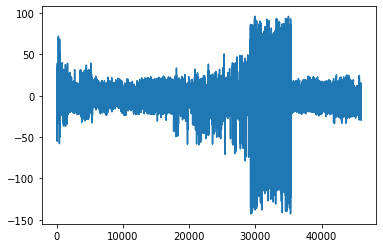

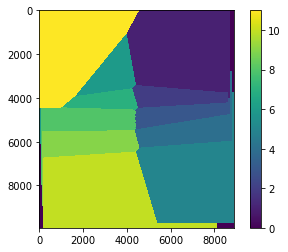

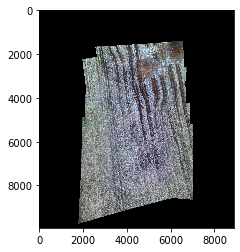

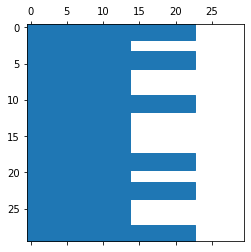

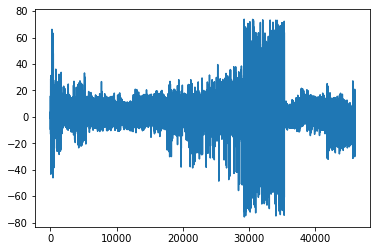

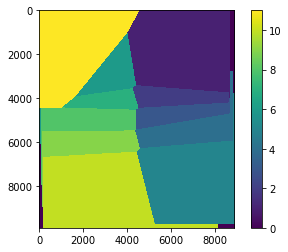

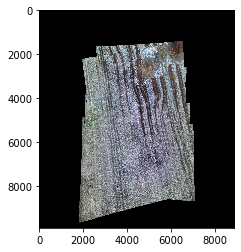

In [3]:
camera_params, points_world_frame, homographys_ba, camera_indices, point_indices, points_camera_frame, n_cameras, n_points, n_observations = prepare_data(
    idx, features,
    matches,
    points_world,
    point_world_idx,
    homographys,
    intrinsic,
    distCoeffs)
x0 = np.hstack((camera_params.ravel(), homographys_ba.ravel(), points_world_frame.ravel()))
print('made initial guess')
f0 = residuals(x0, n_cameras, n_points, n_observations, camera_indices, point_indices, points_camera_frame)
plt.plot(f0)
plt.show()

res_image = multiple_v3(data_undistorted, homographys, 1)
plt.imshow(res_image)
cv2.imwrite('res_image_guess.jpg', res_image)


print('mean residuals= %f' % (np.mean(np.abs(f0))))
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

res = least_squares(residuals, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, n_observations, camera_indices, point_indices, points_camera_frame))
print('performed bundle adjustement')
plt.plot(res.fun)
plt.show()
print('mean residuals= %f'%(np.mean(np.abs(res.fun))))

intrinsic = res.x[:9].reshape(3, 3)
distCoeffs = res.x[9:14]
homographys = res.x[14:14 + n_cameras * 9].reshape(n_cameras, 3, 3)

for i in range(len(data)):
    data[i]=cv2.undistort(data[i], intrinsic, distCoeffs)

res_image = multiple_v3(data, homographys, 1)
plt.imshow(res_image)
cv2.imwrite('res_image.jpg', res_image)
plt.show()
print('intrinsic matrix is:')
print(intrinsic)
print('distortion coeffs are:')
print (distCoeffs)





